# Imports


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

# Load data

In [3]:
# Load the data
train = pd.read_csv("Train.csv")
test = pd.read_csv("test.csv")

# Drop columns and check for missing values

C:\Users\AZIZ\.conda\envs\Tensorflow\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


8    568
9    535
3    500
2    500
1    500
5    500
0    500
6    498
7    487
4    412
Name: Target, dtype: int64

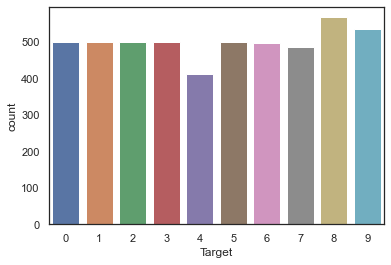

In [4]:
Y_train = train["Target"]

# Drop 'label' column
X_train = train.drop(labels = ["Target",'ID'],axis = 1) 
test.drop('ID',axis=1,inplace=True)

# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

In [5]:
# Check the data
X_train.isnull().any().describe()

count      4096
unique        1
top       False
freq       4096
dtype: object

In [6]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

### Train and test images (64px x 64px) has been stock into pandas.Dataframe as 1D vectors of 4096 values. We reshape all data to 64x64x1 3D matrices.



In [7]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,64,64,1)
test = test.values.reshape(-1,64,64,1)

In [8]:
#Label Encode target values
Y_train = to_categorical(Y_train, num_classes = 10)

In [9]:
# Set the random seed
random_seed = 2
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state=random_seed)

### Custom CNN architechture was takken from 1%top MNIST image classification in Kaggle ( almost same problem in number of classes and training data).

In [10]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (64,64,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))


### Tried multiple optimizers (Adam,Adadelta,Adagrad..), RMSprop gives best results

In [11]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

C:\Users\AZIZ\.conda\envs\Tensorflow\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [12]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


### In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).



In [13]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [14]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

### For the data augmentation, i choosed to :

#### Randomly rotate some training images by 10 degrees
#### Randomly Zoom by 10% some training images
#### Randomly shift images horizontally by 10% of the width
#### Randomly shift images vertically by 10% of the height

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [16]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30


C:\Users\AZIZ\AppData\Local\Temp\ipykernel_14216\923181679.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),


46/46 - 38s - loss: 2.3473 - accuracy: 0.1398 - val_loss: 2.2607 - val_accuracy: 0.1520 - lr: 0.0010 - 38s/epoch - 835ms/step
Epoch 2/30
46/46 - 35s - loss: 2.0382 - accuracy: 0.2624 - val_loss: 1.4764 - val_accuracy: 0.4530 - lr: 0.0010 - 35s/epoch - 767ms/step
Epoch 3/30
46/46 - 34s - loss: 1.5088 - accuracy: 0.4249 - val_loss: 1.1022 - val_accuracy: 0.5540 - lr: 0.0010 - 34s/epoch - 746ms/step
Epoch 4/30
46/46 - 35s - loss: 1.2398 - accuracy: 0.4957 - val_loss: 0.9946 - val_accuracy: 0.5830 - lr: 0.0010 - 35s/epoch - 752ms/step
Epoch 5/30
46/46 - 35s - loss: 1.1034 - accuracy: 0.5470 - val_loss: 0.8687 - val_accuracy: 0.6570 - lr: 0.0010 - 35s/epoch - 759ms/step
Epoch 6/30
46/46 - 35s - loss: 0.9760 - accuracy: 0.6124 - val_loss: 0.6780 - val_accuracy: 0.7530 - lr: 0.0010 - 35s/epoch - 756ms/step
Epoch 7/30
46/46 - 35s - loss: 0.9045 - accuracy: 0.6438 - val_loss: 0.6698 - val_accuracy: 0.7600 - lr: 0.0010 - 35s/epoch - 770ms/step
Epoch 8/30
46/46 - 36s - loss: 0.8064 - accuracy: 0.

46/46 - 36s - loss: 0.5327 - accuracy: 0.7954 - val_loss: 0.4248 - val_accuracy: 0.8480 - lr: 0.0010 - 36s/epoch - 788ms/step
Epoch 29/30
46/46 - 36s - loss: 0.5219 - accuracy: 0.8076 - val_loss: 0.4304 - val_accuracy: 0.8440 - lr: 0.0010 - 36s/epoch - 792ms/step
Epoch 30/30
46/46 - 37s - loss: 0.5277 - accuracy: 0.7989 - val_loss: 0.4364 - val_accuracy: 0.8480 - lr: 0.0010 - 37s/epoch - 810ms/step


### Predict resualt for test set and submit as csv

In [17]:
results = model.predict(test)
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Target")

In [18]:
submission = pd.concat([pd.Series(range(5000),name = "ID"),results],axis = 1)

submission.to_csv("MySub.csv",index=False)